In [1]:
import os
import json
import pickle
import random
import numpy as np
import itertools
import argparse
from tqdm import tqdm, tqdm_notebook
from plotnine import *
import pandas as pd

import cupy
import chainer
from chainer import functions as F

from nlp_utils import convert_seq, convert_snli_seq
from utils import setup_model

from run_dknn import DkNN

/home/t-shfeng/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
parser = argparse.ArgumentParser()
parser.add_argument('--gpu', '-g', type=int, default=0,
                    help='GPU ID (negative value indicates CPU)')
parser.add_argument('--model-setup', required=True,
                    help='Model setup dictionary.')
parser.add_argument('--lsh', action='store_true', default=False,
                    help='If true, uses locally sensitive hashing \
                          (with k=10 NN) for NN search.')
args = parser.parse_args(['--model-setup', 'result/snli_bilstm/args.json'])

model, train, test, vocab, setup = setup_model(args)
if setup['dataset'] == 'snli' and not setup['combine_snli']:
    converter = convert_snli_seq
else:
    converter = convert_seq

# FIXME
args.batchsize = 64
max_beam_size = 5

{
  "gpu": 0,
  "model_setup": "result/snli_bilstm/args.json",
  "lsh": false
}
{
  "batchsize": 128,
  "epoch": 10,
  "gpu": 0,
  "out": "result",
  "unit": 300,
  "layer": 3,
  "dropout": 0.4,
  "combine_snli": false,
  "dataset": "snli",
  "model": "bilstm",
  "char_based": false,
  "word_vectors": null,
  "save_path": "/home/t-shfeng/deep-knn/result/snli_bilstm",
  "vocab_path": "/home/t-shfeng/deep-knn/result/snli_bilstm/vocab.json",
  "model_path": "/home/t-shfeng/deep-knn/result/snli_bilstm/best_model.npz",
  "n_class": 3,
  "datetime": "2018-07-09 07:48:46.853809"
}


download snli
read snli
construct vocabulary based on frequency
# train data: 550152
# test  data: 10000
# vocab: 39431
# class: 3


In [15]:
with open(os.path.join(setup['save_path'], 'calib.json')) as f:
    calibration_idx = json.load(f)

calibration = [train[i] for i in calibration_idx]
train = [x for i, x in enumerate(train) if i not in calibration_idx]
train = random.sample(train, 10000)

In [16]:
dknn = DkNN(model)
dknn.build(train, batch_size=setup['batchsize'], converter=converter, device=args.gpu)
dknn.calibrate(calibration, batch_size=setup['batchsize'], converter=converter, device=args.gpu)

  4%|▍         | 3/78 [00:00<00:03, 20.62it/s]

caching hiddens


79it [00:03, 20.61it/s]                        


using KDTree for NN Search
building tree for layer 0
building tree for layer 1
building tree for layer 2
building tree for layer 3


  0%|          | 0/7 [00:00<?, ?it/s]

calibrating credibility


8it [01:07,  8.44s/it]                       


In [17]:
conf = {'confidence': [], 'data': [], 'label': [], 'type': []}
dis = {'distance': [], 'data': [], 'label': []}

In [18]:
ckp = pickle.load(open('rawr_dev.pkl', 'rb'))
rd_test =  [x[0]['reduced_input'] for x in ckp]

test = test
rd_test = rd_test

In [19]:
og_iter = chainer.iterators.SerialIterator(test, args.batchsize, repeat=False, shuffle=False)

n_batches = len(test) // args.batchsize
for batch in tqdm_notebook(og_iter, total=n_batches):
    batch = converter(batch, device=args.gpu)
    knn_pred, knn_cred, knn_conf, reg_pred, reg_conf = dknn.predict(batch['xs'], calibrated=True, snli=True)
    conf['confidence'].extend(reg_conf)
    conf['data'].extend('original' for _ in reg_conf)
    conf['label'].extend(reg_pred)
    conf['type'].extend('reg_conf' for _ in reg_conf)
    
    conf['confidence'].extend(knn_conf)
    conf['data'].extend('original' for _ in knn_conf)
    conf['label'].extend(knn_pred)
    conf['type'].extend('knn_conf' for _ in knn_conf)
    
    conf['confidence'].extend(knn_cred)
    conf['data'].extend('original' for _ in knn_cred)
    conf['label'].extend(knn_pred)
    conf['type'].extend('knn_cred' for _ in knn_cred)
    
    ds = dknn.get_nearest_distance(batch['xs'], layer_id=0)
    dis['distance'].extend(ds)
    dis['data'].extend('original' for _ in ds)
    dis['label'].extend(knn_pred)

In [20]:
rd_iter = chainer.iterators.SerialIterator(rd_test, args.batchsize, repeat=False, shuffle=False)

n_batches = len(rd_test) // args.batchsize
for batch in tqdm_notebook(rd_iter, total=n_batches):
    batch = converter(batch, device=args.gpu, with_label=False)
    knn_pred, knn_cred, knn_conf, reg_pred, reg_conf = dknn.predict(batch, calibrated=True, snli=True)
    conf['confidence'].extend(reg_conf)
    conf['data'].extend('reduced' for _ in reg_conf)
    conf['label'].extend(reg_pred)
    conf['type'].extend('reg_conf' for _ in reg_conf)
    
    conf['confidence'].extend(knn_conf)
    conf['data'].extend('reduced' for _ in knn_conf)
    conf['label'].extend(knn_pred)
    conf['type'].extend('knn_conf' for _ in knn_conf)
    
    conf['confidence'].extend(knn_cred)
    conf['data'].extend('reduced' for _ in knn_cred)
    conf['label'].extend(knn_pred)
    conf['type'].extend('knn_cred' for _ in knn_cred)
    
    ds = dknn.get_nearest_distance(batch, layer_id=0)
    dis['distance'].extend(ds)
    dis['data'].extend('reduced' for _ in ds)
    dis['label'].extend(knn_pred)

In [21]:
conf = pd.DataFrame(conf)
dis = pd.DataFrame(dis)

In [22]:
(
    ggplot(conf) +
    aes(x='confidence', color='data', fill='data') +
    geom_density(alpha=.45) +
    facet_grid('type ~ label')
)

/home/t-shfeng/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/home/t-shfeng/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/home/t-shfeng/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
/home/t-shfeng/anaconda3/lib/python3.6/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/home/t-shfeng/anaconda3/lib/python3.6/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: divide by zer

ValueError: zero-size array to reduction operation maximum which has no identity

/home/t-shfeng/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/home/t-shfeng/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/home/t-shfeng/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


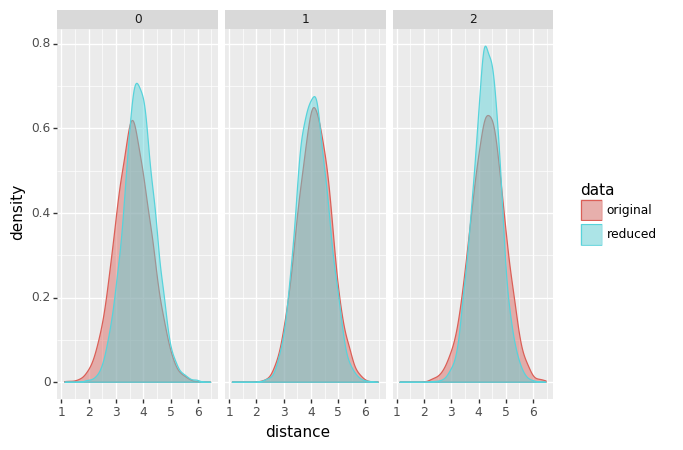

<ggplot: (-9223363261982951196)>

In [23]:
(
    ggplot(dis) +
    aes(x='distance', color='data', fill='data') +
    geom_density(alpha=0.45) + 
    facet_wrap('label')
)